In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [166]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
hashed_feature = pd.read_csv('hashed_feature.csv')
tabular_data = pd.read_csv('tabular_data.csv')

Let's take a look!

In [4]:
train

,id,target
0,0,0
1,1,0
2,2,1
3,3,0
4,4,1
...,...,...
4079,4079,0
4080,4080,0
4081,4081,0
4082,4082,0


In [23]:
test

,id,score
0,4084,NaN
1,4085,NaN
2,4086,NaN
3,4087,NaN
4,4088,NaN
...,...,...
1017,5101,NaN
1018,5102,NaN
1019,5103,NaN
1020,5104,NaN


In [24]:
hashed_feature

,id,feature_50
0,0,7984b0a0e139cabadb5afc7756d473fb34d23819
1,0,47904b3331202e9881d003ff449c2eabfbc75460
2,0,a99c4b3af723874ddd85af322beea81b64437294
3,0,4dce5381031a88aed6b12ef71b6f7c3148e7b3c8
4,0,d62db721202cb6636887f450a7b77fa97db03b05
...,...,...
266048,5104,b800c944804d341038e06d26cf560562942069e9
266049,5104,442e9a74e42ad60348408428654a686c4ed222ee
266050,5105,ff3c67182640fdbd26d2273a87c3311f45c68ae2
266051,5105,95ea6c6f652cb29edc327a2449eb8115ebc6841e


In [25]:
tabular_data

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0,1,110.0,55.0,0.432017,0.000000,176.78,0.0,0.323712,NaN,147.0,0.000000,176.78,55.0,0.248711,0.001373,0.0,0.0,0.0,0.476549,333.60,0.277617,55.0,0.0,55.0,21.0,0.0,f9ae10397ed62e79c644d06842bbcd92963a5927,NaN,0.0,1.00,55.000000,93.0,5562.0,93.0,0.040283,182.0,0.000000,43.50,0.0,0.000000,0.00,0.00,0,0.000000,0.0,55.0,2.0,0.526552,145.0,133.28,0.0
1,0,2,110.0,110.0,0.397517,0.000000,315.42,0.0,0.316798,NaN,135.0,0.000000,315.42,110.0,0.261744,-0.002248,0.0,0.0,0.0,0.210951,428.78,0.290904,110.0,0.0,110.0,26.0,0.0,f9ae10397ed62e79c644d06842bbcd92963a5927,NaN,0.0,0.77,110.000000,114.0,5532.0,114.0,0.047588,181.0,0.000000,85.45,0.0,0.000000,15.75,0.00,0,0.000000,0.0,110.0,1.0,0.481063,130.0,229.97,0.0
2,0,3,110.0,55.0,0.359440,0.000000,354.55,0.0,0.339188,NaN,181.0,0.000000,354.48,55.0,0.302164,0.002083,0.0,0.0,0.0,0.058675,526.38,0.284842,55.0,0.0,55.0,36.0,0.0,f9ae10397ed62e79c644d06842bbcd92963a5927,NaN,0.0,0.05,85249.281058,135.0,5501.0,136.0,0.051470,180.0,0.000000,122.70,0.0,0.000000,0.00,0.07,0,0.000000,0.0,55.0,1.0,0.509598,180.0,231.78,0.0
3,0,4,110.0,55.0,0.285707,0.000000,229.98,0.0,0.415428,NaN,142.0,0.000000,229.98,55.0,0.347660,0.005207,0.0,0.0,0.0,0.966854,398.98,0.285235,55.0,0.0,55.0,30.0,0.0,f9ae10397ed62e79c644d06842bbcd92963a5927,NaN,0.0,0.00,55.000000,102.0,5471.0,102.0,0.076190,179.0,0.000000,46.15,0.0,0.000000,0.00,0.00,0,0.000000,0.0,55.0,0.0,0.680089,142.0,183.83,0.0
4,0,5,110.0,55.0,0.101487,444.730391,307.12,0.0,0.569670,NaN,92.0,0.000000,306.17,55.0,0.438425,0.025736,0.0,21.0,0.0,0.700180,215.17,0.161147,55.0,0.0,55.0,20.0,0.0,11e623a37e87cf7995c466723ec99688d55cae8c,NaN,0.0,0.00,55.000000,82.0,5440.0,95.0,0.273205,178.0,373.498562,150.33,0.0,0.000000,26.75,0.95,0,20.014485,0.0,55.0,0.0,0.776175,85.0,155.83,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61267,5105,8,110.0,77.0,NaN,0.000000,95.30,0.0,0.094381,221.85,-44.0,0.000000,94.93,77.0,0.094811,0.001840,NaN,0.0,0.0,0.128621,227.88,0.341981,75.0,2.0,77.0,11.0,0.0,b204e1e3743cc314841070435211e25f4602b9fd,48.0,0.0,0.00,76.000000,59.0,3324.0,60.0,0.021342,109.0,0.000000,10.97,0.0,0.790865,6.03,-0.00,0,0.000000,0.0,75.0,0.0,0.082128,43.0,83.97,0.0
61268,5105,9,110.0,77.0,NaN,0.000000,61.87,0.0,0.105878,343.22,52.0,0.000000,60.12,77.0,0.099966,0.001545,NaN,0.0,0.0,0.086625,361.98,0.341363,75.0,2.0,77.0,14.0,0.0,b204e1e3743cc314841070435211e25f4602b9fd,42.0,0.0,0.00,76.000000,56.0,3294.0,57.0,0.025601,108.0,0.000000,12.10,0.0,0.047577,17.30,1.75,0,0.000000,0.0,75.0,0.0,0.077594,49.0,48.02,0.0
61269,5105,10,110.0,106.5,NaN,0.000000,88.05,0.0,0.040169,259.33,46.0,4676.517443,79.78,106.5,0.000000,1.000000,NaN,0.0,0.0,0.665468,282.57,0.000000,99.0,7.5,106.5,6.0,0.0,b204e1e3743cc314841070435211e25f4602b9fd,29.0,0.0,0.63,99.000000,35.0,3263.0,38.0,0.000000,107.0,0.000000,5.27,0.0,0.777481,22.60,8.27,0,0.000000,0.0,99.0,1.0,0.109053,43.0,74.52,0.0
61270,5105,11,110.0,45.0,NaN,0.000000,98.40,0.0,0.040810,222.00,-39.0,0.000000,98.40,45.0,0.000000,1.000000,NaN,0.0,0.0,0.586869,243.13,0.000000,0.0,45.0,45.0,7.0,0.0,b204e1e3743cc314841070435211e25f4602b9fd,26.0,0.0,0.00,28.000000,33.0,3235.0,33.0,0.000000,106.0,0.000000,72.57,0.0,0.065075,21.13,0.00,0,0.000000,0.0,0.0,0.0,0.101929,35.0,25.83,0.0


In [97]:
train.loc[train['target'] == 1].count()

id        1075
target    1075
dtype: int64

In [98]:
train.loc[train['target'] == 0].count()

id        3009
target    3009
dtype: int64

Seems like we have kind of skew data. "Nondrivers" and "Drivers" correlate in proportion 3:1. That's a lot. Below we will try to undersample the date and compare the results with training on a full sample.

In [17]:
zero_guy = tabular_data.loc[tabular_data['id'] == 0]

In [18]:
zero_guy

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0,1,110.0,55.00,0.432017,0.000000,176.78,0.0,0.323712,NaN,147.0,0.00,176.78,55.00,0.248711,0.001373,0.0,0.0,0.000000,0.476549,333.60,0.277617,55.00,0.00,55.00,21.0,0.0,f9ae10397ed62e79c644d06842bbcd92963a5927,NaN,0.00,1.00,55.000000,93.0,5562.0,93.0,0.040283,182.0,0.000000,43.50,0.0,0.0,0.00,0.00,0,0.000000,0.0,55.00,2.0,0.526552,145.0,133.28,0.0
1,0,2,110.0,110.00,0.397517,0.000000,315.42,0.0,0.316798,NaN,135.0,0.00,315.42,110.00,0.261744,-0.002248,0.0,0.0,0.000000,0.210951,428.78,0.290904,110.00,0.00,110.00,26.0,0.0,f9ae10397ed62e79c644d06842bbcd92963a5927,NaN,0.00,0.77,110.000000,114.0,5532.0,114.0,0.047588,181.0,0.000000,85.45,0.0,0.0,15.75,0.00,0,0.000000,0.0,110.00,1.0,0.481063,130.0,229.97,0.0
2,0,3,110.0,55.00,0.359440,0.000000,354.55,0.0,0.339188,NaN,181.0,0.00,354.48,55.00,0.302164,0.002083,0.0,0.0,0.000000,0.058675,526.38,0.284842,55.00,0.00,55.00,36.0,0.0,f9ae10397ed62e79c644d06842bbcd92963a5927,NaN,0.00,0.05,85249.281058,135.0,5501.0,136.0,0.051470,180.0,0.000000,122.70,0.0,0.0,0.00,0.07,0,0.000000,0.0,55.00,1.0,0.509598,180.0,231.78,0.0
3,0,4,110.0,55.00,0.285707,0.000000,229.98,0.0,0.415428,NaN,142.0,0.00,229.98,55.00,0.347660,0.005207,0.0,0.0,0.000000,0.966854,398.98,0.285235,55.00,0.00,55.00,30.0,0.0,f9ae10397ed62e79c644d06842bbcd92963a5927,NaN,0.00,0.00,55.000000,102.0,5471.0,102.0,0.076190,179.0,0.000000,46.15,0.0,0.0,0.00,0.00,0,0.000000,0.0,55.00,0.0,0.680089,142.0,183.83,0.0
4,0,5,110.0,55.00,0.101487,444.730391,307.12,0.0,0.569670,NaN,92.0,0.00,306.17,55.00,0.438425,0.025736,0.0,21.0,0.000000,0.700180,215.17,0.161147,55.00,0.00,55.00,20.0,0.0,11e623a37e87cf7995c466723ec99688d55cae8c,NaN,0.00,0.00,55.000000,82.0,5440.0,95.0,0.273205,178.0,373.498562,150.33,0.0,0.0,26.75,0.95,0,20.014485,0.0,55.00,0.0,0.776175,85.0,155.83,0.0
5,0,6,110.0,55.00,0.083655,92.284390,277.02,0.0,0.494765,NaN,110.0,0.00,276.78,55.00,0.429781,0.030347,0.0,18.0,0.000000,0.544730,279.12,0.142850,55.00,0.00,55.00,42.0,0.0,11e623a37e87cf7995c466723ec99688d55cae8c,NaN,0.00,0.77,55.000000,106.0,5409.0,113.0,0.313367,177.0,51.409212,89.58,0.0,0.0,38.37,0.24,0,0.250835,0.0,55.00,1.0,-0.702192,98.0,187.20,0.0
6,0,7,110.0,55.00,0.107765,543.138844,690.38,0.0,0.522715,NaN,190.0,0.00,688.82,55.00,0.433959,0.018277,0.0,2.0,0.000000,0.173358,399.53,0.160262,55.00,0.00,55.00,38.0,0.0,11e623a37e87cf7995c466723ec99688d55cae8c,NaN,0.00,0.00,55.000000,193.0,5379.0,205.0,0.279737,176.0,482.808738,194.85,0.0,0.0,0.00,1.56,0,37.356612,0.0,55.00,0.0,0.679334,190.0,493.97,0.0
7,0,8,110.0,55.00,0.097857,578.379486,619.35,0.0,0.537815,NaN,178.0,0.00,618.18,55.00,0.431441,0.019732,0.0,9.0,0.000000,0.150241,466.77,0.160802,55.00,0.00,55.00,46.0,0.0,11e623a37e87cf7995c466723ec99688d55cae8c,NaN,0.00,0.00,55.000000,176.0,5348.0,189.0,0.290168,175.0,481.871825,143.23,0.0,0.0,0.00,1.17,0,17.235488,0.0,55.00,0.0,0.711163,178.0,474.95,0.0
8,0,9,110.0,55.75,0.179713,186.258945,539.15,0.0,0.547634,NaN,125.0,0.00,538.78,55.75,0.438065,0.011378,0.0,2.0,0.000000,0.677110,268.70,0.197743,55.75,0.00,55.75,56.0,0.0,11e623a37e87cf7995c466723ec99688d55cae8c,NaN,0.00,0.72,80615.165370,194.0,5318.0,199.0,0.173101,174.0,185.152871,143.82,0.0,0.0,0.00,0.37,0,33.149051,0.0,55.75,2.0,0.634992,123.0,394.97,0.0
9,0,10,110.0,60.00,0.129596,1099.289203,608.28,0.0,0.438465,NaN,152.0,0.00,607.95,60.00,0.433901,0.016291,0.0,11.0,16814.310306,0.751816,315.77,0.161442,55.75,4.25,60.00,32.0,0.0,11e623a37e87cf7995c466723ec99688d55cae8c,NaN,0.00,4.57

In [99]:
hf_count = hashed_feature.groupby('id')['feature_50'].nunique()
print(hf_count)

id
0        10
1        43
2        14
3         6
4        52
       ... 
5101    107
5102     83
5103      6
5104     10
5105      3
Name: feature_50, Length: 5106, dtype: int64


In [100]:
hf_count = hashed_feature.groupby('feature_50').nunique()
print(hf_count)

                                          id
feature_50                                  
000063d721c1f034be95d0208c9b695ae4c4a7ff  15
0004424eef8f9bf1292d5db1b747974102dba0c3  12
000f3ba943b7e58a5d676205c090ef812941a160  67
00190bc7e4a8816794ab97d128bafd54b5fa7d98   3
00191d9d44fd37f680cffbb0dfc5d30ae26581ff  18
...                                       ..
ffc6bd16e0f7c6f106089f3bae741006a2423afc  83
ffcba4846ef0f01e3b0476d0bf0b5d058fccb9f7  17
ffd80e85ec84a0fee0ce0af3416da95810ced13c  46
ffdae33cc90c7a30c4f70d285c0f54fdc1ee1e26   4
ffe6792b7bfe19bd83d705f0be606101fc4b5ac3  31

[5009 rows x 1 columns]


This data is terrifying. We have to do something with it.

At first, I tried to leave it as it is, apply groupby (as I will do next), add it to the table of other features and call got_dummies on all categorical data... But I got TOO many features, and my RAM became a "food" for my model as a result. So I came up with the weird method below))

In [167]:
hashed_feature_np = hashed_feature.to_numpy(copy=True)

In [168]:
hashed_feature_np

array([[0, '7984b0a0e139cabadb5afc7756d473fb34d23819'],
       [0, '47904b3331202e9881d003ff449c2eabfbc75460'],
       [0, 'a99c4b3af723874ddd85af322beea81b64437294'],
       ...,
       [5105, 'ff3c67182640fdbd26d2273a87c3311f45c68ae2'],
       [5105, '95ea6c6f652cb29edc327a2449eb8115ebc6841e'],
       [5105, '5e5065e69ff338ad1ea7b533bfba891e432a4737']], dtype=object)

In [169]:
hashed = np.zeros((hashed_feature_np.shape[0]))
for i in range(hashed_feature_np.shape[0]):
  hashed[i] = hash(hashed_feature_np[i][1])

In [170]:
from sklearn.preprocessing import normalize

hashed = hashed / np.linalg.norm(hashed)

In [171]:
hashed_feature['feature_50_new'] = hashed

In [172]:
hashed_feature

,id,feature_50,feature_50_new
0,0,7984b0a0e139cabadb5afc7756d473fb34d23819,0.002225
1,0,47904b3331202e9881d003ff449c2eabfbc75460,0.002433
2,0,a99c4b3af723874ddd85af322beea81b64437294,0.000594
3,0,4dce5381031a88aed6b12ef71b6f7c3148e7b3c8,-0.001100
4,0,d62db721202cb6636887f450a7b77fa97db03b05,-0.000855
...,...,...,...
266048,5104,b800c944804d341038e06d26cf560562942069e9,0.001035
266049,5104,442e9a74e42ad60348408428654a686c4ed222ee,-0.002679
266050,5105,ff3c67182640fdbd26d2273a87c3311f45c68ae2,0.001331
266051,5105,95ea6c6f652cb29edc327a2449eb8115ebc6841e,0.001314


In [117]:
hf_count = hashed_feature.groupby('feature_50_new').nunique()
print(hf_count)

                 id  feature_50
feature_50_new                 
-0.003368        53           1
-0.003367       128           1
-0.003363         4           1
-0.003361         8           1
-0.003360         3           1
...             ...         ...
 0.003360        65           1
 0.003362        30           1
 0.003362        24           1
 0.003364        29           1
 0.003367        25           1

[5010 rows x 2 columns]


In [173]:
hashed_feature = hashed_feature.drop(['feature_50'], axis=1)

In [174]:
hashed_feature['idx'] = hashed_feature.groupby(['id']).cumcount()

hashed_feature['feature_50_new_idx'] = 'feature_50_new_' + hashed_feature.idx.astype(str)

feature_50_new = hashed_feature.pivot(index=['id'], columns='feature_50_new_idx', values='feature_50_new')
print(feature_50_new)

feature_50_new_idx  feature_50_new_0  ...  feature_50_new_999
id                                    ...                    
0                           0.002225  ...                 NaN
1                           0.001934  ...                 NaN
2                           0.001024  ...                 NaN
3                          -0.000531  ...                 NaN
4                          -0.000695  ...                 NaN
...                              ...  ...                 ...
5101                       -0.002279  ...                 NaN
5102                       -0.002696  ...                 NaN
5103                       -0.003343  ...                 NaN
5104                        0.001211  ...                 NaN
5105                        0.001331  ...                 NaN

[5106 rows x 1278 columns]


In [176]:
tabular_data = tabular_data.groupby(['id']).mean()

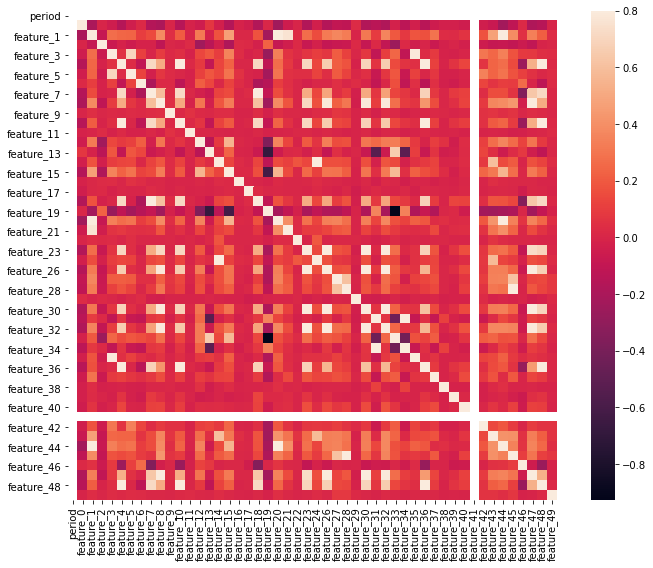

In [211]:
corrmat = tabular_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Beautiful heatmap! It could help us learn more about the features, but time make us move on.

In [177]:
train_all = pd.concat([tabular_data, feature_50_new], axis=1)

In [178]:
train_all

,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,...,feature_50_new_963,feature_50_new_964,feature_50_new_965,feature_50_new_966,feature_50_new_967,feature_50_new_968,feature_50_new_969,feature_50_new_97,feature_50_new_970,feature_50_new_971,feature_50_new_972,feature_50_new_973,feature_50_new_974,feature_50_new_975,feature_50_new_976,feature_50_new_977,feature_50_new_978,feature_50_new_979,feature_50_new_98,feature_50_new_980,feature_50_new_981,feature_50_new_982,feature_50_new_983,feature_50_new_984,feature_50_new_985,feature_50_new_986,feature_50_new_987,feature_50_new_988,feature_50_new_989,feature_50_new_99,feature_50_new_990,feature_50_new_991,feature_50_new_992,feature_50_new_993,feature_50_new_994,feature_50_new_995,feature_50_new_996,feature_50_new_997,feature_50_new_998,feature_50_new_999
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,6.5,110.000000,60.916667,0.238880,293.635812,430.134167,0.000000,0.445332,NaN,147.666667,0.311667,429.397500,60.916667,0.360890,0.012619,0.000000,6.750000,1401.192525,0.474502,375.895833,0.213995,59.875000,0.708333,60.916667,35.750000,0.000000,NaN,0.195833,0.681667,13873.703869,137.500000,5394.500000,142.916667,0.173240,176.500000,257.850618,114.386667,0.333333,0.000000,15.724167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.5,110.000000,135.541667,0.060443,6940.579852,1119.352500,0.000000,0.350638,1199.843333,114.500000,399.374874,1115.622500,3578.271570,0.276305,0.130849,0.083333,19.583333,1424.045299,0.506484,1205.569167,0.150180,125.000000,3.041667,135.541667,29.583333,0.083333,NaN,0.049167,5.229167,135.346667,123.916667,4865.500000,89.333333,0.382223,159.500000,6745.593512,303.854167,7.500000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.5,110.166667,0.597500,5.203073,0.141369,4.168333,0.000000,0.875014,NaN,10.166667,0.000000,3.711667,0.597500,0.219482,0.018294,0.000000,0.416667,0.000000,0.586389,36.360000,0.331008,0.597500,0.000000,0.597500,-1.000000,0.000000,4.166667,0.000000,0.000000,6803.169012,6.333333,4189.500000,7.166667,0.101093,137.500000,0.000000,1.240833,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6.5,110.000000,62.500000,2.589315,1515.795679,75.613333,0.000000,0.695500,164.350000,107.000000,3.440000,71.493333,62.500000,0.172660,0.271826,2.000000,10.333333,5255.187465,0.313672,165.963333,0.030409,51.376667,11.123333,62.500000,11.666667,2.000000,43.000000,1.726667,1.613333,65.833333,54.666667,38.666667,65.333333,0.516865,1.000000,756.642422,16.176667,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.5,110.000000,126.000000,0.133693,2568.283478,460.332500,0.000000,1.006855,522.449167,227.583333,44.445833,412.505000,126.000000,0.396319,0.016331,0.083333,21.083333,0.166667,0.455603,589.747500,0.247121,103.733333,21.016667,3697.957374,22.250000,0.166667,91.250000,18.172500,66.545000,123.166667,119.666667,5133.500000,NaN,0.206536,168.500000,1478.299501,107.006667,1.250000,0.000000,0.541667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

It's time to deal with numerical features...

In [181]:
from scipy.stats import skew

numeric_feats = train_all.dtypes[train_all.dtypes != "object"].index

skewed_feats = train_all[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

train_all[skewed_feats] = np.log1p(train_all[skewed_feats])

print(train_all)

      period  feature_0  ...  feature_50_new_998  feature_50_new_999
id                       ...                                        
0        6.5   4.709530  ...                 NaN                 NaN
1        6.5   4.709530  ...                 NaN                 NaN
2        6.5   4.711031  ...                 NaN                 NaN
3        6.5   4.709530  ...                 NaN                 NaN
4        6.5   4.709530  ...                 NaN                 NaN
...      ...        ...  ...                 ...                 ...
5101     6.5   4.709530  ...                 NaN                 NaN
5102     6.5   4.709530  ...                 NaN                 NaN
5103     6.5   4.711780  ...                 NaN                 NaN
5104     6.5   4.709530  ...                 NaN                 NaN
5105     6.5   4.709530  ...                 NaN                 NaN

[5106 rows x 1328 columns]


...and with categorical ones as well.

In [182]:
train_all = pd.get_dummies(train_all)

In [183]:
train_all

,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,...,feature_50_new_963,feature_50_new_964,feature_50_new_965,feature_50_new_966,feature_50_new_967,feature_50_new_968,feature_50_new_969,feature_50_new_97,feature_50_new_970,feature_50_new_971,feature_50_new_972,feature_50_new_973,feature_50_new_974,feature_50_new_975,feature_50_new_976,feature_50_new_977,feature_50_new_978,feature_50_new_979,feature_50_new_98,feature_50_new_980,feature_50_new_981,feature_50_new_982,feature_50_new_983,feature_50_new_984,feature_50_new_985,feature_50_new_986,feature_50_new_987,feature_50_new_988,feature_50_new_989,feature_50_new_99,feature_50_new_990,feature_50_new_991,feature_50_new_992,feature_50_new_993,feature_50_new_994,feature_50_new_995,feature_50_new_996,feature_50_new_997,feature_50_new_998,feature_50_new_999
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,6.5,4.709530,4.125789,0.214207,5.685740,6.066419,0.000000,0.368339,NaN,5.001707,0.271299,6.064709,4.125789,0.360890,0.012540,0.000000,6.750000,7.245792,0.474502,5.931969,0.213995,4.108823,0.535518,4.125789,3.604138,0.000000,NaN,0.178843,0.519785,9.537823,4.930870,5394.500000,4.969234,0.173240,176.500000,5.556251,4.748289,0.287682,0.000000,2.816855,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.5,4.709530,4.916630,0.058687,8.845285,7.021399,0.000000,0.300577,7.090779,4.749271,5.992401,7.018064,8.182915,0.276305,0.122969,0.080043,19.583333,7.261959,0.506484,7.095536,0.150180,4.836282,1.396657,4.916630,3.420455,0.080043,NaN,0.047996,1.829243,4.915201,4.827647,4865.500000,4.503507,0.382223,159.500000,8.816793,5.719834,2.140066,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.5,4.711031,0.468440,1.825045,0.132229,1.642550,0.000000,0.628616,NaN,2.412933,0.000000,1.550042,0.468440,0.219482,0.018129,0.000000,0.416667,0.000000,0.586389,3.620601,0.331008,0.468440,0.000000,0.468440,-inf,0.000000,1.642228,0.000000,0.000000,8.825291,1.992430,4189.500000,2.100061,0.101093,137.500000,0.000000,0.806848,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6.5,4.709530,4.151040,1.277961,7.324355,4.338771,0.000000,0.527977,5.108064,4.682131,1.490654,4.283495,4.151040,0.172660,0.240454,1.098612,10.333333,8.567161,0.313672,5.117774,0.030409,3.958461,2.495132,4.151040,2.538974,1.098612,3.784190,1.003080,0.960627,4.202202,4.019382,38.666667,4.194693,0.516865,1.000000,6.630212,2.843552,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.5,4.709530,4.844187,0.125480,7.851382,6.134119,0.000000,0.696569,6.260440,5.431901,3.816521,6.024670,4.844187,0.396319,0.016199,0.080043,21.083333,0.154151,0.455603,6.381389,0.247121,4.651417,3.091800,8.215806,3.146305,0.154151,4.524502,2.953477,4.212794,4.821625,4.793032,5133.500000,NaN,0.206536,168.500000,7.299324,4.682193,0.810930,0.000000,0.432864,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

Now - infs and NaNs. Perhaps this is not the best way to solve this issue, but if only we knew a little more about the data and had a little more time ... For now, let's just fill in the missing data using mean.

In [192]:
train_all = train_all.replace([np.inf, -np.inf], np.nan)

In [193]:
train_all = train_all.fillna(train_all.mean())

In [194]:
train_all = train_all.fillna(0)

In [195]:
train_all

,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,...,feature_50_new_963,feature_50_new_964,feature_50_new_965,feature_50_new_966,feature_50_new_967,feature_50_new_968,feature_50_new_969,feature_50_new_97,feature_50_new_970,feature_50_new_971,feature_50_new_972,feature_50_new_973,feature_50_new_974,feature_50_new_975,feature_50_new_976,feature_50_new_977,feature_50_new_978,feature_50_new_979,feature_50_new_98,feature_50_new_980,feature_50_new_981,feature_50_new_982,feature_50_new_983,feature_50_new_984,feature_50_new_985,feature_50_new_986,feature_50_new_987,feature_50_new_988,feature_50_new_989,feature_50_new_99,feature_50_new_990,feature_50_new_991,feature_50_new_992,feature_50_new_993,feature_50_new_994,feature_50_new_995,feature_50_new_996,feature_50_new_997,feature_50_new_998,feature_50_new_999
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,6.5,4.709530,4.125789,0.214207,5.685740,6.066419,0.000000,0.368339,5.397234,5.001707,0.271299,6.064709,4.125789,0.360890,0.012540,0.000000,6.750000,7.245792,0.474502,5.931969,0.213995,4.108823,0.535518,4.125789,3.604138,0.000000,3.982823,0.178843,0.519785,9.537823,4.930870,5394.500000,4.969234,0.173240,176.500000,5.556251,4.748289,0.287682,0.000000,2.816855,...,-0.000864,0.000797,-0.00127,-0.001856,-0.002718,-0.001979,0.001613,0.000045,-0.002591,-0.001785,-0.002282,-0.000417,-0.003214,0.002601,-0.001656,-0.001009,-0.002606,-0.002994,-0.000120,-0.001527,-0.003367,0.002263,-0.0008,0.003165,0.002987,-0.002541,0.001383,0.00025,0.000952,-0.000030,-0.003053,-0.003322,-0.001644,0.001584,0.003049,-0.002485,-0.000535,-0.002616,0.000273,-0.002484
1,6.5,4.709530,4.916630,0.058687,8.845285,7.021399,0.000000,0.300577,7.090779,4.749271,5.992401,7.018064,8.182915,0.276305,0.122969,0.080043,19.583333,7.261959,0.506484,7.095536,0.150180,4.836282,1.396657,4.916630,3.420455,0.080043,3.982823,0.047996,1.829243,4.915201,4.827647,4865.500000,4.503507,0.382223,159.500000,8.816793,5.719834,2.140066,0.000000,0.000000,...,-0.000864,0.000797,-0.00127,-0.001856,-0.002718,-0.001979,0.001613,0.000045,-0.002591,-0.001785,-0.002282,-0.000417,-0.003214,0.002601,-0.001656,-0.001009,-0.002606,-0.002994,-0.000120,-0.001527,-0.003367,0.002263,-0.0008,0.003165,0.002987,-0.002541,0.001383,0.00025,0.000952,-0.000030,-0.003053,-0.003322,-0.001644,0.001584,0.003049,-0.002485,-0.000535,-0.002616,0.000273,-0.002484
2,6.5,4.711031,0.468440,1.825045,0.132229,1.642550,0.000000,0.628616,5.397234,2.412933,0.000000,1.550042,0.468440,0.219482,0.018129,0.000000,0.416667,0.000000,0.586389,3.620601,0.331008,0.468440,0.000000,0.468440,2.820738,0.000000,1.642228,0.000000,0.000000,8.825291,1.992430,4189.500000,2.100061,0.101093,137.500000,0.000000,0.806848,0.000000,0.000000,0.000000,...,-0.000864,0.000797,-0.00127,-0.001856,-0.002718,-0.001979,0.001613,0.000045,-0.002591,-0.001785,-0.002282,-0.000417,-0.003214,0.002601,-0.001656,-0.001009,-0.002606,-0.002994,-0.000120,-0.001527,-0.003367,0.002263,-0.0008,0.003165,0.002987,-0.002541,0.001383,0.00025,0.000952,-0.000030,-0.003053,-0.003322,-0.001644,0.001584,0.003049,-0.002485,-0.000535,-0.002616,0.000273,-0.002484
3,6.5,4.709530,4.151040,1.277961,7.324355,4.338771,0.000000,0.527977,5.108064,4.682131,1.490654,4.283495,4.151040,0.172660,0.240454,1.098612,10.333333,8.567161,0.313672,5.117774,0.030409,3.958461,2.495132,4.151040,2.538974,1.098612,3.784190,1.003080,0.960627,4.202202,4.019382,38.666667,4.194693,0.516865,1.000000,6.630212,2.843552,0.000000,0.000000,0.000000,...,-0.000864,0.000797,-0.00127,-0.001856,-0.002718,-0.001979,0.001613,0.000045,-0.002591,-0.001785,-0.002282,-0.000417,-

It's time to train our models!

In [196]:
data_train = train_all.iloc[:3062, 2:]
data_cv = train_all.iloc[3062:4084, 2:]

In [197]:
y_train = train.iloc[0:3062]
y_cv = train.iloc[3062:]

In [198]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(data_train, y_train['target'])
predictions = clf.predict(data_cv)

In [199]:
from sklearn.metrics import classification_report
print(classification_report(y_cv['target'], predictions))

              precision    recall  f1-score   support

           0       0.74      0.97      0.84       743
           1       0.54      0.08      0.14       279

    accuracy                           0.73      1022
   macro avg       0.64      0.53      0.49      1022
weighted avg       0.68      0.73      0.65      1022



In [200]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(data_train, y_train['target'])
predictions = neigh.predict(data_cv)

In [201]:
from sklearn.metrics import classification_report
print(classification_report(y_cv['target'], predictions))

              precision    recall  f1-score   support

           0       0.72      0.87      0.79       743
           1       0.22      0.10      0.14       279

    accuracy                           0.66      1022
   macro avg       0.47      0.48      0.46      1022
weighted avg       0.58      0.66      0.61      1022



In [202]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(data_train, y_train['target'])
predictions = clf.predict(data_cv)

In [203]:
from sklearn.metrics import classification_report
print(classification_report(y_cv['target'], predictions))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       743
           1       0.39      0.40      0.40       279

    accuracy                           0.67      1022
   macro avg       0.58      0.58      0.58      1022
weighted avg       0.67      0.67      0.67      1022



In [205]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(data_train, y_train['target'])
predictions = clf.predict(data_cv)

In [206]:
from sklearn.metrics import classification_report
print(classification_report(y_cv['target'], predictions))

              precision    recall  f1-score   support

           0       0.75      0.98      0.85       743
           1       0.69      0.13      0.22       279

    accuracy                           0.75      1022
   macro avg       0.72      0.55      0.54      1022
weighted avg       0.73      0.75      0.68      1022



In [208]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0)
clf.fit(data_train, y_train['target'])
predictions = clf.predict(data_cv)

In [210]:
from sklearn.metrics import classification_report
print(classification_report(y_cv['target'], predictions))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       743
           1       0.64      0.26      0.37       279

    accuracy                           0.76      1022
   macro avg       0.71      0.60      0.61      1022
weighted avg       0.74      0.76      0.72      1022



As we can see from the obtained f1-score, our models clearly have problems with positive values (yes, skew data!). It's time to try undersampling the data and see what happens.

In [212]:
new_train = train.sort_values(by='target', ascending=False).iloc[:2150,:]

In [213]:
new_train = new_train.sample(frac=1)

In [214]:
new_train

,id,target
3198,3198,0
634,634,1
1552,1552,1
2706,2706,0
2330,2330,1
...,...,...
3975,3975,1
3812,3812,1
2754,2754,1
1448,1448,1


In [215]:
new_train.loc[train['target'] == 1].count()

id        1075
target    1075
dtype: int64

In [216]:
new_train.loc[train['target'] == 0].count()

id        1075
target    1075
dtype: int64

In [217]:
new_train_all = train_all.iloc[new_train['id']]

In [218]:
new_train_all

,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,...,feature_50_new_963,feature_50_new_964,feature_50_new_965,feature_50_new_966,feature_50_new_967,feature_50_new_968,feature_50_new_969,feature_50_new_97,feature_50_new_970,feature_50_new_971,feature_50_new_972,feature_50_new_973,feature_50_new_974,feature_50_new_975,feature_50_new_976,feature_50_new_977,feature_50_new_978,feature_50_new_979,feature_50_new_98,feature_50_new_980,feature_50_new_981,feature_50_new_982,feature_50_new_983,feature_50_new_984,feature_50_new_985,feature_50_new_986,feature_50_new_987,feature_50_new_988,feature_50_new_989,feature_50_new_99,feature_50_new_990,feature_50_new_991,feature_50_new_992,feature_50_new_993,feature_50_new_994,feature_50_new_995,feature_50_new_996,feature_50_new_997,feature_50_new_998,feature_50_new_999
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3198,6.5,4.710281,2.187922,0.091430,0.111917,1.054022,0.114305,0.666169,2.505254,2.538974,0.141933,0.939682,2.187922,0.304306,0.122544,0.000000,0.000000,7.194814,0.666499,2.776280,0.149388,2.187922,0.000000,2.187922,0.773190,0.000000,1.126011,0.000000,1.571044,2.187922,1.446919,369.5,1.704748,0.320196,9.833333,0.000187,0.423632,0.000000,0.0,0.000000,...,-0.000864,0.000797,-0.00127,-0.001856,-0.002718,-0.001979,0.001613,0.000045,-0.002591,-0.001785,-0.002282,-0.000417,-0.003214,0.002601,-0.001656,-0.001009,-0.002606,-0.002994,-0.000120,-0.001527,-0.003367,0.002263,-0.0008,0.003165,0.002987,-0.002541,0.001383,0.00025,0.000952,-0.000030,-0.003053,-0.003322,-0.001644,0.001584,0.003049,-0.002485,-0.000535,-0.002616,0.000273,-0.002484
634,6.5,4.709530,5.078932,0.423027,7.198646,5.950554,2.076713,0.634788,5.555627,4.652372,2.361168,5.907297,8.202489,0.223288,0.067499,0.594552,7.333333,0.287682,0.602604,5.695235,0.231641,4.197465,4.011899,5.078932,3.713572,0.223144,4.804704,0.850863,3.623563,8.832164,5.088111,554.5,4.695163,0.386122,14.833333,5.174789,4.533271,3.709499,0.0,0.799757,...,-0.000864,0.000797,-0.00127,-0.001856,-0.002718,-0.001979,0.001613,-0.000465,-0.002591,-0.001785,-0.002282,-0.000417,-0.003214,0.002601,-0.001656,-0.001009,-0.002606,-0.002994,0.001317,-0.001527,-0.003367,0.002263,-0.0008,0.003165,0.002987,-0.002541,0.001383,0.00025,0.000952,0.001147,-0.003053,-0.003322,-0.001644,0.001584,0.003049,-0.002485,-0.000535,-0.002616,0.000273,-0.002484
1552,6.5,4.709530,4.640304,0.452749,0.012727,5.084722,0.000000,0.526221,5.124614,3.857215,0.683097,5.074971,4.640304,0.313597,0.053984,0.000000,0.333333,0.000000,0.388137,5.145676,0.252345,4.521145,2.536471,4.640304,2.966132,0.000000,3.830451,0.364643,1.521153,4.644319,4.166665,1274.5,4.192177,0.213345,35.166667,0.012727,3.831283,0.000000,0.0,0.000000,...,-0.000864,0.000797,-0.00127,-0.001856,-0.002718,-0.001979,0.001613,0.000045,-0.002591,-0.001785,-0.002282,-0.000417,-0.003214,0.002601,-0.001656,-0.001009,-0.002606,-0.002994,-0.000120,-0.001527,-0.003367,0.002263,-0.0008,0.003165,0.002987,-0.002541,0.001383,0.00025,0.000952,-0.000030,-0.003053,-0.003322,-0.001644,0.001584,0.003049,-0.002485,-0.000535,-0.002616,0.000273,-0.002484
2706,6.5,4.709530,4.754043,0.072807,8.650542,5.750746,8.499680,0.438426,5.707310,5.751779,4.100299,5.537141,4.754043,0.489818,0.016663,0.650588,24.000000,7.241774,0.668355,5.901558,0.170744,4.644479,2.568277,8.228546,3.473518,0.650588,5.420166,2.648123,4.179643,4.754308,5.563882,5056.5,5.806138,0.244028,137.833333,6.667159,4.064844,0.000000,0.0,0.185788,...,-0.000864,0.000797,-0.00127,-0.001856,-0.002718,-0.001979,0.001613,0.000045,-0.002591,-0.001785,-0.002282,-0.000417,-0.003214,0.002601,-0.001656,-0.00

In [219]:
data_train = new_train_all.iloc[:1419, 2:]
data_cv = new_train_all.iloc[1419:, 2:]

In [220]:
y_train = new_train.iloc[0:1419]
y_cv = new_train.iloc[1419:]

In [221]:
y_train

,id,target
3198,3198,0
634,634,1
1552,1552,1
2706,2706,0
2330,2330,1
...,...,...
897,897,1
3377,3377,1
2382,2382,0
928,928,1


In [222]:
y_train['target'].value_counts()

0    721
1    698
Name: target, dtype: int64

In [223]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(data_train, y_train['target'])
predictions = clf.predict(data_cv)

In [224]:
from sklearn.metrics import classification_report
print(classification_report(y_cv['target'], predictions))

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       354
           1       0.65      0.65      0.65       377

    accuracy                           0.63       731
   macro avg       0.63      0.63      0.63       731
weighted avg       0.63      0.63      0.63       731



In [225]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(data_train, y_train['target'])
predictions = neigh.predict(data_cv)

In [226]:
from sklearn.metrics import classification_report
print(classification_report(y_cv['target'], predictions))

              precision    recall  f1-score   support

           0       0.48      0.47      0.47       354
           1       0.51      0.53      0.52       377

    accuracy                           0.50       731
   macro avg       0.50      0.50      0.50       731
weighted avg       0.50      0.50      0.50       731



In [228]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(data_train, y_train['target'])
predictions = clf.predict(data_cv)

In [229]:
from sklearn.metrics import classification_report
print(classification_report(y_cv['target'], predictions))

              precision    recall  f1-score   support

           0       0.58      0.66      0.61       354
           1       0.63      0.55      0.58       377

    accuracy                           0.60       731
   macro avg       0.60      0.60      0.60       731
weighted avg       0.60      0.60      0.60       731



In [230]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(data_train, y_train['target'])
predictions = clf.predict(data_cv)

In [231]:
from sklearn.metrics import classification_report
print(classification_report(y_cv['target'], predictions))

              precision    recall  f1-score   support

           0       0.66      0.69      0.67       354
           1       0.69      0.67      0.68       377

    accuracy                           0.68       731
   macro avg       0.68      0.68      0.68       731
weighted avg       0.68      0.68      0.68       731



In [232]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0)
clf.fit(data_train, y_train['target'])
predictions = clf.predict(data_cv)

In [233]:
from sklearn.metrics import classification_report
print(classification_report(y_cv['target'], predictions))

              precision    recall  f1-score   support

           0       0.68      0.73      0.70       354
           1       0.72      0.67      0.70       377

    accuracy                           0.70       731
   macro avg       0.70      0.70      0.70       731
weighted avg       0.70      0.70      0.70       731



Let's try to stay on this option - at least, f1-score is balanced now. The GradientBoostingClassifier seems to have worked the best. Let's now run test samples on it.

In [234]:
data_train = new_train_all.iloc[:, 2:]
data_test = train_all.iloc[4084:, 2:]

In [239]:
data_test

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,...,feature_50_new_963,feature_50_new_964,feature_50_new_965,feature_50_new_966,feature_50_new_967,feature_50_new_968,feature_50_new_969,feature_50_new_97,feature_50_new_970,feature_50_new_971,feature_50_new_972,feature_50_new_973,feature_50_new_974,feature_50_new_975,feature_50_new_976,feature_50_new_977,feature_50_new_978,feature_50_new_979,feature_50_new_98,feature_50_new_980,feature_50_new_981,feature_50_new_982,feature_50_new_983,feature_50_new_984,feature_50_new_985,feature_50_new_986,feature_50_new_987,feature_50_new_988,feature_50_new_989,feature_50_new_99,feature_50_new_990,feature_50_new_991,feature_50_new_992,feature_50_new_993,feature_50_new_994,feature_50_new_995,feature_50_new_996,feature_50_new_997,feature_50_new_998,feature_50_new_999
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4084,4.431967,0.269825,6.993520,5.653433,0.000000,0.184827,6.052289,4.803338,1.976970,5.600666,4.327350,0.289818,0.015089,0.080043,5.166667,7.207619,0.535169,6.090648,0.224926,4.311246,2.357389,4.431967,2.397895,0.223144,3.944813,0.727549,2.830022,8.892549,4.209655,4283.500000,4.484884,0.143127,117.333333,7.014368,4.212177,0.000000,0.000000,0.517305,1.557794,0.0,...,-0.000864,0.000797,-0.00127,-0.001856,-0.002718,-0.001979,0.001613,0.000045,-0.002591,-0.001785,-0.002282,-0.000417,-0.003214,0.002601,-0.001656,-0.001009,-0.002606,-0.002994,-0.000120,-0.001527,-0.003367,0.002263,-0.0008,0.003165,0.002987,-0.002541,0.001383,0.00025,0.000952,-0.000030,-0.003053,-0.003322,-0.001644,0.001584,0.003049,-0.002485,-0.000535,-0.002616,0.000273,-0.002484
4085,4.418841,0.229503,0.000056,4.250873,0.000000,1.866338,4.527749,3.821369,0.000000,4.241375,9.276251,0.265582,0.016437,0.287682,0.666667,0.287682,0.423026,4.575123,0.342383,4.410776,0.510826,4.418841,2.268684,0.287682,3.850148,0.000000,0.546193,10.245403,4.019382,54.666667,4.077537,0.117487,1.000000,0.000056,3.028683,0.000000,0.000000,1.560248,0.157004,0.0,...,-0.000864,0.000797,-0.00127,-0.001856,-0.002718,-0.001979,0.001613,0.000045,-0.002591,-0.001785,-0.002282,-0.000417,-0.003214,0.002601,-0.001656,-0.001009,-0.002606,-0.002994,-0.000120,-0.001527,-0.003367,0.002263,-0.0008,0.003165,0.002987,-0.002541,0.001383,0.00025,0.000952,-0.000030,-0.003053,-0.003322,-0.001644,0.001584,0.003049,-0.002485,-0.000535,-0.002616,0.000273,-0.002484
4086,4.205936,0.222456,0.005418,7.128080,0.000000,0.026872,7.500208,5.767018,6.015805,7.116721,8.152232,0.235107,0.012694,0.000000,0.083333,0.000000,0.518345,7.502415,0.361657,4.169504,1.223775,4.205936,4.358843,0.000000,5.627321,0.135405,0.526699,8.878173,5.951727,2016.500000,5.737915,0.141321,65.500000,0.000000,5.834928,0.000000,0.000000,1.457063,-0.002503,0.0,...,-0.000864,0.000797,-0.00127,-0.001856,-0.002718,-0.001979,0.001613,0.000045,-0.002591,-0.001785,-0.002282,-0.000417,-0.003214,0.002601,-0.001656,-0.001009,-0.002606,-0.002994,-0.000120,-0.001527,-0.003367,0.002263,-0.0008,0.003165,0.002987,-0.002541,0.001383,0.00025,0.000952,-0.000030,-0.003053,-0.003322,-0.001644,0.001584,0.003049,-0.002485,-0.000535,-0.002616,0.000273,-0.002484
4087,3.603004,0.202591,7.133310,4.614840,7.095527,0.754005,6.071336,4.425844,6.028509,4.523834,8.212169,0.292340,0.031866,0.223144,20.916667,0.223144,0.613510,6.139302,0.272184,3.406738,2.020443,8.132090,1.749200,0.080043,3.511545,0.715398,3.449061,3.637586,3.652820,5603.500000,3.931826,0.178526,153.000000,2.752637,2.979815,0.000000,0.000000,0.000000,1.012812,0.0,...,-0.000864,0.000797,-0.00127,-0.001856,-0.002718,-0.001979,0.001613,0.000045,-0.002591,-0.001785,-0.0

In [235]:
y_train = new_train

In [237]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0)
clf.fit(data_train, y_train['target'])
predictions = clf.predict(data_test)

In [240]:
test['score'] = predictions

In [241]:
test

,id,score
0,4084,0
1,4085,0
2,4086,0
3,4087,1
4,4088,1
...,...,...
1017,5101,0
1018,5102,1
1019,5103,0
1020,5104,1
